# **KHANIF FAUZI PAMBUDI (MILESTONE 2 PHASE 2)**

**ABOUT DATA**

The data used is sourced from Twitter from SXSW 2013, and contains tweets about the SXSW tech events and product announcements. Most of the tweets are about Apple and Google, and many mention specific products. The raw data can be found in the data folder in this repository.

The data was manually labeled for classification, and contains the tweet text, the product or brand mentioned, and the sentiment as interpreted by the labeler.

**GOALS**

The resulting model will be used to classify tweets from future tech conferences from Google and Apple, and analyze how sentiment for the brands has changed over time.

I'll be evaluating my model based on accuracy score to understand how the model is performing holistically.

# **INSTALLING LIBRARY**

In [ ]:
# Adding external libraries
!pip install -q keras
!pip install -q h5py
!pip install -q matplotlib
!pip install -q nltk
!pip install -q gensim

# **IMPORT LIBRARY**

In [ ]:
import pandas as pd
import numpy as np

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

#text processing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import re
import nltk
import string
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords

#NLP modeling
from gensim.models import Word2Vec
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')

# **DATA LOADING**

In [ ]:
df = pd.read_csv('/content/judge-1377884607_tweet_product_company.csv', encoding = 'latin')

In [ ]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [ ]:
df.tail()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product
9092,Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...,NaN,No emotion toward brand or product


# **DATA EXPLORATION**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [ ]:
df.shape

(9093, 3)

In [ ]:
df.columns

Index(['tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directed_at_a_brand_or_product'],
      dtype='object')

In [ ]:
df.describe().T

,count,unique,top,freq
tweet_text,9092,9065,RT @mention Marissa Mayer: Google Will Connect...,5
emotion_in_tweet_is_directed_at,3291,9,iPad,946
is_there_an_emotion_directed_at_a_brand_or_product,9093,4,No emotion toward brand or product,5389


In [ ]:
df.emotion_in_tweet_is_directed_at.value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

**sentimen kelas**

Melihat sentimennya, sepertinya sebagian besar berlabel netral dan sebenarnya sangat sedikit tweet negatif. Saya berasumsi karena tweet dari pengumuman produk di SXSW, jadi suasananya terfokus pada kegembiraan atau berita seputar peluncuran produk baru.

In [ ]:
df.is_there_an_emotion_directed_at_a_brand_or_product.value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

**Mengecek kategori 'I can't tell'**

Melihat lebih dekat pada kategori 'I can't tell', saya melakukan hal ini karena saya ingin melihat apakah saya dapat mengelompokkannya dengan netral atau apakah saya harus mengabaikannya.

In [ ]:
ct_df = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'I can\'t tell']
ct_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
90,Thanks to @mention for publishing the news of ...,NaN,I can't tell
102,ÛÏ@mention &quot;Apple has opened a pop-up st...,NaN,I can't tell
237,Just what America needs. RT @mention Google to...,NaN,I can't tell
341,The queue at the Apple Store in Austin is FOUR...,NaN,I can't tell
368,Hope it's better than wave RT @mention Buzz is...,NaN,I can't tell


Setelah data ditampilkan terlihat datanya campuran. Saya akan menghapus data tersebut karena saya rasa sudah ada lebih banyak kelas netral dan jika tidak dihapus maka hanya akan berkontribusi pada ketidakseimbangan kelas.

In [ ]:
df = df.drop([row for row in ct_df.index])

**Mengecek Kategori Netral**

Saya juga ingin melihat tweet netral dan terlihat cukup netral. Jadi saya akan membuat kolom pengklasifikasi baru untuk mengurutkannya menjadi: -1 untuk negatif dan 1 untuk positif. Netral akan menjadi default 0.

In [ ]:
ne_df = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'No emotion toward brand or product']
ne_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
16,Holler Gram for iPad on the iTunes App Store -...,NaN,No emotion toward brand or product
32,"Attn: All #SXSW frineds, @mention Register fo...",NaN,No emotion toward brand or product
33,Anyone at #sxsw want to sell their old iPad?,NaN,No emotion toward brand or product


Saya juga dapat melihat bahwa sebagian besar tweet netral juga tidak memiliki label produk yang terkait sehingga mereka benar-benar tidak memberikan banyak informasi. Pada akhirnya, saya ingin menyimpan tweet netral dalam data yang saya gunakan karena tanpa mereka, kumpulan data akan sangat sedikit.

**Membuat kolom pengklasifikasian**

In [ ]:
df['class'] = 0
for row in df.index:
    if df['is_there_an_emotion_directed_at_a_brand_or_product'][row] == 'Positive emotion':
        df['class'][row] = 1
    elif df['is_there_an_emotion_directed_at_a_brand_or_product'][row] == 'Negative emotion':
        df['class'][row] = -1
        
df.head(6)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,class
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,-1
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,1
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,1
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,-1
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,1
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product,0


# **MISSING VALUE**

mengecek apakah terdapat missing value atau tidak

In [ ]:
df.isnull().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5655
is_there_an_emotion_directed_at_a_brand_or_product       0
class                                                    0
dtype: int64

setelah dicek ternyata ada 1 missing value pada kolom tweet_text dan ada 5655 missing value pada kolom emotion_in_tweet_is_directed_at





**Treatment terhadap missing value**

In [ ]:
nulls_df = df[df['emotion_in_tweet_is_directed_at'].isna()]
nulls_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,class
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product,0
6,NaN,NaN,No emotion toward brand or product,0
16,Holler Gram for iPad on the iTunes App Store -...,NaN,No emotion toward brand or product,0
32,"Attn: All #SXSW frineds, @mention Register fo...",NaN,No emotion toward brand or product,0
33,Anyone at #sxsw want to sell their old iPad?,NaN,No emotion toward brand or product,0


In [ ]:
nulls_df1 = df[df['tweet_text'].isna()]
nulls_df1.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,class
6,NaN,NaN,No emotion toward brand or product,0


**Mengisi kolom yang terdapat missing value dengan sebuah nilai**

In [ ]:
df['tweet_text'] = df['tweet_text'].fillna('lorem ipsum dolor sit amet')

In [ ]:
df['emotion_in_tweet_is_directed_at'] = df['emotion_in_tweet_is_directed_at'].fillna('unspecified')

setelah diisi dengan value maka dicek kembali apakah sudah terisi semua value nya atau belum

In [ ]:
df.isnull().sum()

tweet_text                                            0
emotion_in_tweet_is_directed_at                       0
is_there_an_emotion_directed_at_a_brand_or_product    0
class                                                 0
dtype: int64

setelah dilakukan treatment missing value maka semua kolom sudah terisi dengan nilai

**Membuat kolom brand untuk re-kategori**

Untuk memvisualisasikan bagaimana sentimen berbeda menurut merek dalam kumpulan data ini, saya akan mengumpulkan datanya secara visual. Pertama, saya perlu mengisi value NA. Kemudian agar terlihat lebih bersih, saya akan mengurutkan semua sub produk menjadi hanya Google atau Apple.

In [ ]:
# creating a new column to recategorize

df['Brand Mentioned'] = df['emotion_in_tweet_is_directed_at']

#replacing all subproducts with their parent brand
for row in df.index:
    if df['Brand Mentioned'][row] == 'Android':
        df['Brand Mentioned'][row] = 'Google'
    elif df['Brand Mentioned'][row] == 'Other Google product or service':
        df['Brand Mentioned'][row] = 'Google'
    elif df['Brand Mentioned'][row] == 'Android App':
        df['Brand Mentioned'][row] = 'Google'
        
    elif df['Brand Mentioned'][row] == 'iPad or Apple App':
        df['Brand Mentioned'][row] = 'Apple'
    elif df['Brand Mentioned'][row] == 'iPad or iPhone App':
        df['Brand Mentioned'][row] = 'Apple'
    elif df['Brand Mentioned'][row] == 'iPad':
        df['Brand Mentioned'][row] = 'Apple'
    elif df['Brand Mentioned'][row] == 'iPhone':
        df['Brand Mentioned'][row] = 'Apple'
    elif df['Brand Mentioned'][row] == 'Other Apple product or service':
        df['Brand Mentioned'][row] = 'Apple'

In [ ]:
#using a groupby to grab the product and sentiment
group = df.groupby(['class', 'Brand Mentioned']).count()[
    'is_there_an_emotion_directed_at_a_brand_or_product']

Text(0, 0.5, 'Occurrences by Brand')

<Figure size 1800x1080 with 0 Axes>

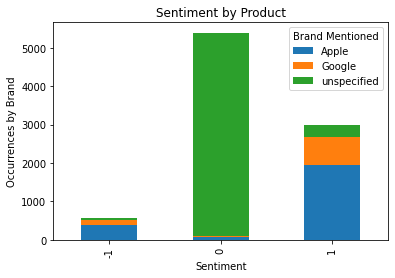

In [ ]:
plt.figure(figsize=(25, 15))
fig = group.unstack().plot(kind='bar', stacked=True, align="center")

fig.set_title('Sentiment by Product')

fig.set_xlabel('Sentiment')
fig.set_ylabel('Occurrences by Brand')

Seperti yang bisa kita lihat, sebagian besar tweet netral tidak dilabeli oleh produk. Dari sisi negatif dan positifnya, mayoritas tentang produk Apple. Grafik menunjukkan bahwa sentimen tidak selalu berbeda untuk setiap merek, tetapi percakapan secara keseluruhan cenderung lebih banyak tentang Apple.

# **EDA**

berikut ini adalah grafik persebaran sentimen pada dataset

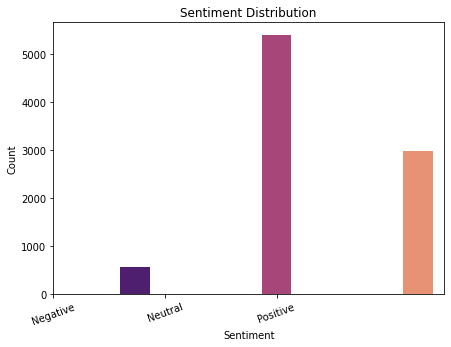

In [ ]:
plt.figure (figsize=(7,5))
ax = sns.countplot(x = 'class', hue = 'class', data = df, palette = 'magma')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks([-1, 1, 0], ['Negative', 'Positive', 'Neutral'], rotation=20)
ax.get_legend().remove()

plt.show()

dapat dilihat pada grafik bahwa sentimen netral memiliki dominasi terhadap persebaran sentimen

**Persebaran sentimen terhadap emotion pada tweet**



**Sentimen negatif**

In [ ]:
negative = df[df['class'] == -1 ].groupby('emotion_in_tweet_is_directed_at').count()
negative = negative.drop(columns=['tweet_text', 'is_there_an_emotion_directed_at_a_brand_or_product'])

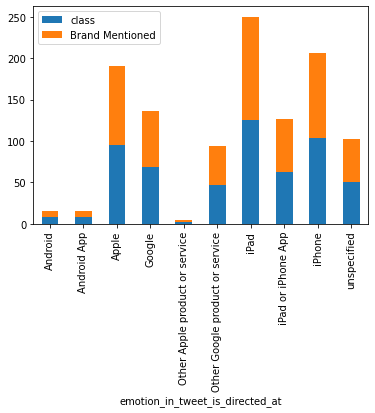

In [ ]:
negative.plot(kind='bar', stacked=True)

**Sentimen Positif**

In [ ]:
positive = df[df['class'] == 1].groupby('emotion_in_tweet_is_directed_at').count()
positive = positive.drop(columns=['tweet_text', 'is_there_an_emotion_directed_at_a_brand_or_product'])

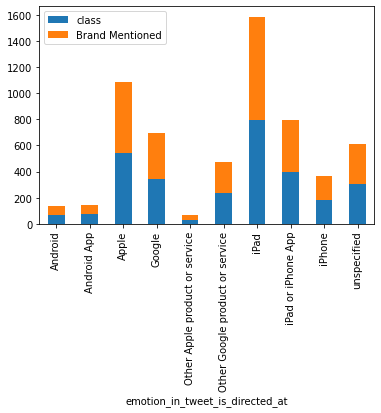

In [ ]:
positive.plot(kind='bar', stacked=True)

**Sentimen Netral**

In [ ]:
neutral = df[df['class'] == 0].groupby('emotion_in_tweet_is_directed_at').count()
neutral = neutral.drop(columns=['tweet_text', 'is_there_an_emotion_directed_at_a_brand_or_product'])

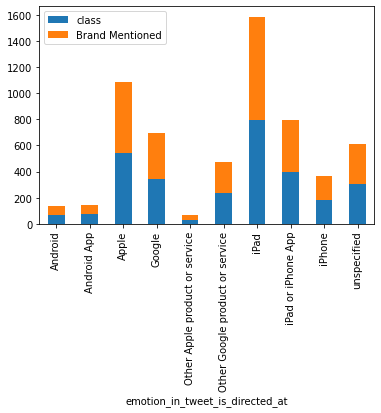

In [ ]:
positive.plot(kind='bar', stacked=True)

# **EDA ANALYSIS**



*   Dari persebaran data terhadap sentimen, sentimen yang bernilai netral memiliki dominasi terhadap sentimen pada dataset
*   Untuk sentimen yang bernilai negatif merek yang paling sering disebut adalah ipad, diikuti dengan apple dan google

*   Untuk sentimen yang bernilai positif merek yang paling sering disebut adalah ipad juga dan diikuti dengan apple lalu google
*   Dari hasil sentimen negatif dan positif dapat dilihat bahwa merek yang sering disebut dikedua sentimen sama ini dapat dijadikan hipotesa bahwa terdapat pro dan kontra terhadap merek-merek tersebut

*   Untuk sentimen yang bernilai netral pun juga sama bahwa merek yang sering disebut adalah ipad, apple, lalu google







# **DATA PREPROCESSING**

Untuk memproses data saya akan membuat kolom baru untuk teks yang akan diproses. Langkah pertama yang akan saya ambil adalah menghapus karakter-karakter yang tidak perlu menggunakan regular expression, karena karakter tersebut bukan konten aktual.

In [ ]:
df['clean_tweet'] = [re.sub(r'(http://[^"\s]+)|(@\w+)', '', tweet) for tweet in df['tweet_text']]

In [ ]:
print(df.iloc[12][0])
print(df.iloc[12][4])

Foursquare ups the game, just in time for #SXSW http://j.mp/grN7pK) - Still prefer @Gowalla by far, best looking Android app to date.
Google


**Stopwords**

Sekarang, saya dapat menyusun daftar stopwords dari NLTK sehingga saya dapat menghapus semua kata dalam teks yang sebenarnya tidak mengandung informasi apa pun. Selain itu saya akan menghapus tanda baca ketika tweet diberi token, sehingga tagar dapat dibaca sebagai kata-kata.

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stopwords_list = stopwords.words('english')
stopwords_list += string.punctuation
punct_list = ["''", '""', '...', '``']
stopwords_list += punct_list

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

**Memproses tweet**

Sebelum membuat model, saya akan melihat data saat dilakukan tokenisasi. Saya dapat melihat bahwa tanda baca telah dihapus dan setiap tweet telah berubah menjadi daftar kata-kata yang informatif

In [ ]:
# this function will lowercase everything and remove stopwords and punctuation

def process_tweet(tweet):
    tokens = nltk.word_tokenize(tweet)
    words_lower = [token.lower() for token in tokens]
    words_stopped = [word for word in words_lower if word not in stopwords_list]
    return words_stopped

#previewing the results
processed_data = list(map(process_tweet, df['clean_tweet']))

processed_data[0]

['3g',
 'iphone',
 '3',
 'hrs',
 'tweeting',
 'rise_austin',
 'dead',
 'need',
 'upgrade',
 'plugin',
 'stations',
 'sxsw']

In [ ]:
#creating a list of unique words in the data set

total_vocab = set()
for token in processed_data:
    total_vocab.update(token)
    
print(len(total_vocab))

10455


Pada step ini dengan stopwords maka  dihasilkan 10.455 kata unik.

**Melakukan compile frequency dictionary**

Saya akan membuat frequency dictionary untuk melihat kata-kata yang paling sering muncul. Beberapa yang paling sering adalah kata umum Twitter - 'rt', 'link'. Namun banyak yang mengacu pada suatu produk dan acara.

In [ ]:
tweet_concat = []
for tweet in processed_data:
    tweet_concat += tweet
    
tweet_freqdist = FreqDist(tweet_concat)
tweet_freqdist.most_common(2000)

[('sxsw', 9352),
 ('link', 4265),
 ('rt', 2926),
 ('google', 2543),
 ('ipad', 2402),
 ('apple', 2267),
 ('quot', 1657),
 ('iphone', 1497),
 ('store', 1455),
 ("'s", 1218),
 ('2', 1104),
 ('new', 1078),
 ('austin', 948),
 ('amp', 834),
 ('app', 811),
 ('launch', 647),
 ('social', 636),
 ('circles', 634),
 ('android', 572),
 ('today', 572),
 ("n't", 467),
 ('network', 458),
 ('ipad2', 455),
 ('pop-up', 411),
 ('via', 405),
 ('line', 393),
 ('free', 387),
 ('get', 383),
 ('called', 354),
 ('party', 345),
 ('mobile', 337),
 ('sxswi', 337),
 ('one', 305),
 ('major', 300),
 ('like', 280),
 ('time', 270),
 ("'re", 262),
 ('temporary', 262),
 ('opening', 256),
 ("'m", 252),
 ('possibly', 236),
 ('downtown', 225),
 ('people', 223),
 ('apps', 222),
 ('great', 221),
 ('see', 218),
 ('maps', 216),
 ('day', 216),
 ('check', 215),
 ('mayer', 214),
 ('going', 213),
 ('open', 209),
 ('popup', 208),
 ('need', 202),
 ('go', 197),
 ('marissa', 189),
 ('got', 182),
 ('know', 181),
 ('w/', 181),
 ('come', 

**word cloud generator**

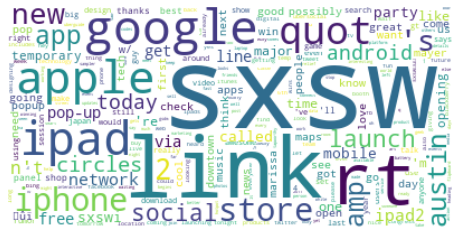

In [ ]:
#instantiating word cloud and using my frequency dictionary to fill it in
wc = WordCloud(background_color="white", max_words=2000)
wc.generate_from_frequencies(tweet_freqdist)

plt.figure(figsize=(8,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.margins(x=1, y=1)
plt.show()

# wc.to_file('Images/word_cloud.png')

# **SPLIT DATA**

Saya akan set teks clean_tweet yang sudah definisikan di atas untuk melatih dan menguji variabel.

In [ ]:
X = df['clean_tweet']
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

Saya juga akan menggunakan count vectorizer dengan model dasar karena ini merupakan salah satu teknik yang lebih sederhana. Count Vectorizer mengubah teks menjadi vektor berdasarkan jumlah setiap kata yang muncul dalam teks.

In [ ]:
count_vectorizer = CountVectorizer(stop_words=stopwords_list)

X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

# **MAKE NLP MODEL**

# **GLOBAL VECTOR LOADING**

Global Vector merupakan representasi Kata pada model yang telah dibuat sebelumnya oleh Stanford NLP Group, yang dilatih pada kumpulan data besar untuk mendapatkan representasi vektor untuk kata-kata.

In [ ]:
#opening glove file and applying it to my data
glove = {}
with open('/content/glove.6B.50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocab:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [ ]:
glove['google']

array([ 9.6900e-01, -6.1799e-01,  1.6561e+00,  1.4079e+00, -6.3774e-02,
       -4.5934e-01, -1.0961e+00, -1.2889e+00,  5.1762e-01,  4.8351e-01,
        5.5815e-03,  2.7758e-01, -6.3178e-01, -4.1388e-01,  4.1559e-01,
        2.7384e-01, -9.0019e-01, -4.8922e-01,  3.8597e-01, -8.1652e-01,
        5.9012e-01, -4.1399e-01, -2.7623e-01,  3.2718e-01,  5.9101e-01,
       -9.1574e-01, -2.5320e-01, -4.3769e-01, -5.1452e-01, -7.0860e-01,
        1.8017e+00, -5.5229e-01, -4.1493e-01, -6.4137e-01, -1.0188e+00,
       -1.1337e+00, -7.7804e-01,  1.5144e-03, -8.1687e-01, -8.0404e-01,
        1.1654e+00, -3.5197e-01, -3.9405e-01,  6.3104e-01, -9.1100e-02,
       -5.1041e-01,  6.5359e-01,  1.1840e-01,  2.9559e-01,  1.8361e-01],
      dtype=float32)

GloVe telah berhasil membuat kata-kata dalam kumpulan data menjadi sebuah vector

# **KELAS VECTORIZER**

berikut merupakan pendefinisian kelas untuk membuat penyisipan kata embedding

In [ ]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    # adding a 'fit' method so I can use in a pipeline
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

# **TOKENIZER**

Di sini saya akan menggunakan tools praprocessing Keras untuk melakukan tokenisasi pada setiap split datanya, mengubahnya menjadi urutan, dan kemudian menambahkan urutannya sehingga semuanya memiliki panjang yang sama.

In [ ]:
tokenizer = text.Tokenizer(num_words=10000)
tokenizer.fit_on_texts(list(X_train))
X_train_tokenized = tokenizer.texts_to_sequences(X_train)
X_test_tokenized = tokenizer.texts_to_sequences(X_test)
X_train_token = sequence.pad_sequences(X_train_tokenized, maxlen=100)
X_test_token = sequence.pad_sequences(X_test_tokenized, maxlen=100)

In [ ]:
X_train_token.shape

(6702, 100)

In [ ]:
y_train_enc = pd.get_dummies(y_train).values
y_test_enc = pd.get_dummies(y_test).values
y_train_enc.shape

(6702, 3)

Kedua variabel tampaknya merupakan dimensi yang tepat. Saatnya membuat model nlp. Saya akan membuat model sekuensial, dimulai dengan lapisan embedding 10.000 kata, yang merupakan jumlah kata dalam tokenizer. Saya mengatur ukuran embedding 100 yang merupakan parameter panjang maksimal yang saya gunakan di atas.

Kemudian saya menambahkan dua lapisan, LSTM dan lapisan padat. Untuk membuatnya tetap sederhana, saya akan menjalankan ini selama 10 epoch.

Model saya akan mengevaluasi akurasi, dan menggunakan fungsi loss dan pengoptimalan yang dipilih.

In [ ]:
np.random.seed(10)
model1 = Sequential()

In [ ]:
embedding_size = 100
model1.add(Embedding(10000, embedding_size))
model1.add(LSTM(25, return_sequences=True))
model1.add(GlobalMaxPool1D())
model1.add(Dense(50, activation='relu'))
model1.add(Dense(3, activation='relu'))

In [ ]:
model1.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

model1.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, None, 100)         1000000   
_________________________________________________________________
lstm_15 (LSTM)               (None, None, 25)          12600     
_________________________________________________________________
global_max_pooling1d_15 (Glo (None, 25)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 50)                1300      
_________________________________________________________________
dense_31 (Dense)             (None, 3)                 153       
Total params: 1,014,053
Trainable params: 1,014,053
Non-trainable params: 0
_________________________________________________________________


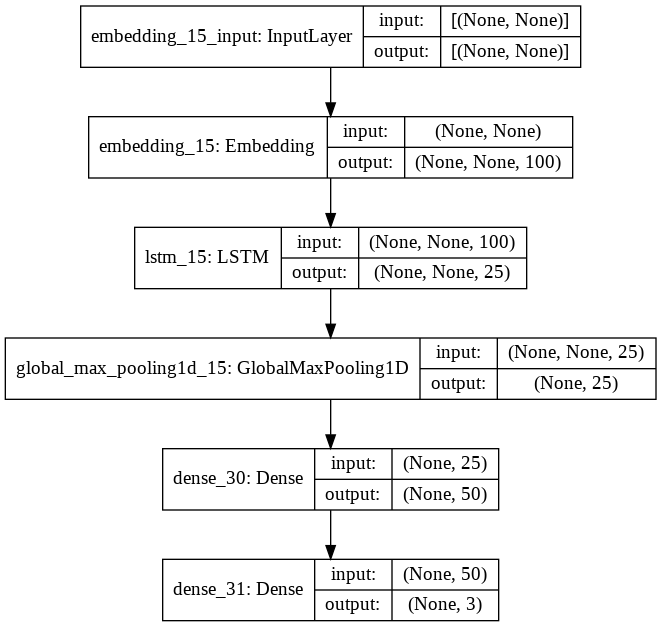

In [ ]:
keras.utils.plot_model(model1, "model1_function.png", show_shapes=True)

In [ ]:
model_val = model1.fit(X_train_token, y_train_enc, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
189/189 [==============================] - 14s 66ms/step - loss: 0.8662 - accuracy: 0.6299 - val_loss: 0.9104 - val_accuracy: 0.6915
Epoch 2/10
189/189 [==============================] - 12s 62ms/step - loss: 0.7962 - accuracy: 0.6448 - val_loss: 0.9469 - val_accuracy: 0.7004
Epoch 3/10
189/189 [==============================] - 12s 62ms/step - loss: 0.6249 - accuracy: 0.7554 - val_loss: 0.7629 - val_accuracy: 0.7034
Epoch 4/10
189/189 [==============================] - 12s 62ms/step - loss: 0.4883 - accuracy: 0.8324 - val_loss: 1.2037 - val_accuracy: 0.7109
Epoch 5/10
189/189 [==============================] - 12s 62ms/step - loss: 0.3917 - accuracy: 0.8881 - val_loss: 1.8954 - val_accuracy: 0.6870
Epoch 6/10
189/189 [==============================] - 12s 61ms/step - loss: nan - accuracy: 0.2834 - val_loss: nan - val_accuracy: 0.0522
Epoch 7/10
189/189 [==============================] - 12s 62ms/step - loss: nan - accuracy: 0.0660 - val_loss: nan - val_accuracy: 0.0522
Epoc

Dalam 10 epoch, model ini telah meningkatkan akurasinya pada 5 epoch pertama namun pada epoch ke 6 sampai terakhir terdapat penurunan yang signifikan, penurunan ini masih diselidiki. Lalu saya akan membuat model lain untuk memberikan sebuah improvement.

# **MODEL EVALUATION**

In [ ]:
def evaluate_nn(model, X_train, X_test, y_train, y_test):
    
    """ 

    This function takes in a fitted neural net and uses the evaluate function to 
    return performance for train and test sets in an easy to read format

    """
        
    results_train = model.evaluate(X_train_token, y_train_enc)
    results_test = model.evaluate(X_test_token, y_test_enc)

    print('----------')
    print(f'Training Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')
    print('----------')
    print(f'Test Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3}')

In [ ]:
#plugging my 'baseline' neural net into this function
evaluate_nn(model1, X_train_token, X_test_token, y_train_enc, y_test_enc)

70/70 [==============================] - 1s 12ms/step - loss: nan - accuracy: 0.0613
----------
Training Loss: nan 
Training Accuracy: 0.0646
----------
Test Loss: nan 
Test Accuracy: 0.0613


Text(0, 0.5, 'Loss')

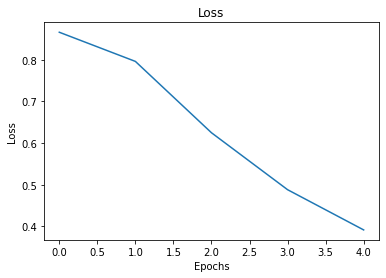

In [ ]:
#access history attribute to get the record
history = model_val.history

#plot loss and then accuracy over time
plt.figure()
plt.plot(history['loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

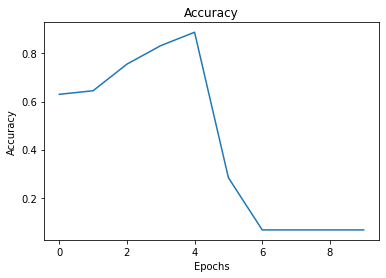

In [ ]:
plt.figure()
plt.plot(history['accuracy'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# **MODEL IMPROVEMENT**

In [ ]:
#new model with dropout layers
np.random.seed(10)
model2 = Sequential()

In [ ]:
model2.add(Embedding(10000, embedding_size))
model2.add(LSTM(25, return_sequences=True))
model2.add(GlobalMaxPool1D())
model2.add(Dropout(0.5))
model2.add(Dense(50, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(3, activation='softmax'))

In [ ]:
model2.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [ ]:
model2.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, None, 100)         1000000   
_________________________________________________________________
lstm_16 (LSTM)               (None, None, 25)          12600     
_________________________________________________________________
global_max_pooling1d_16 (Glo (None, 25)                0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 50)                1300      
_________________________________________________________________
dropout_21 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 3)               

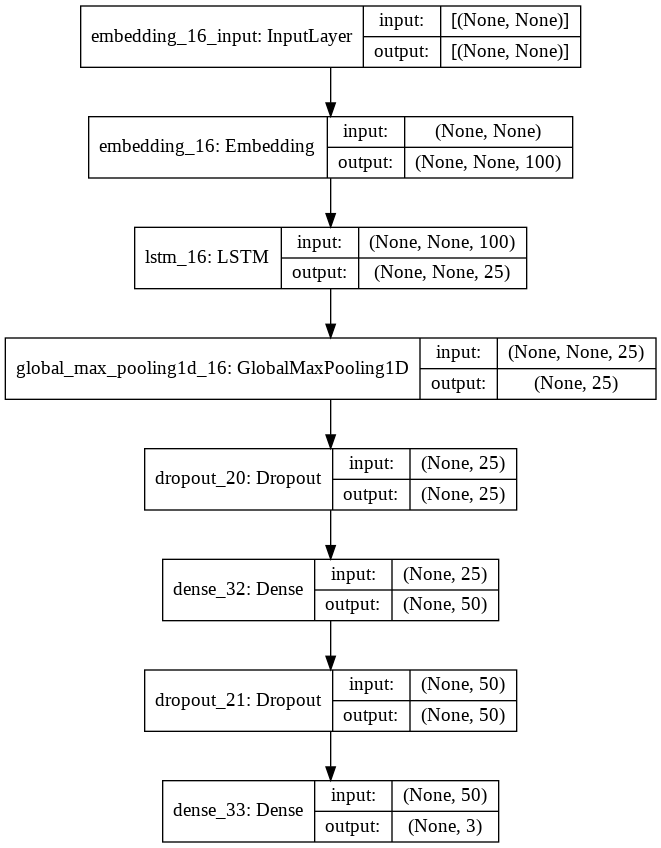

In [ ]:
keras.utils.plot_model(model2, "model2_function.png", show_shapes=True)

In [ ]:
# increasing epochs to 15
model2_val = model2.fit(X_train_token, y_train_enc,
                        epochs=15, batch_size=32)

Epoch 1/15
210/210 [==============================] - 15s 61ms/step - loss: 0.9010 - accuracy: 0.5922
Epoch 2/15
210/210 [==============================] - 13s 61ms/step - loss: 0.7888 - accuracy: 0.6246
Epoch 3/15
210/210 [==============================] - 13s 61ms/step - loss: 0.6505 - accuracy: 0.7123
Epoch 4/15
210/210 [==============================] - 13s 61ms/step - loss: 0.5300 - accuracy: 0.7886
Epoch 5/15
210/210 [==============================] - 13s 61ms/step - loss: 0.4364 - accuracy: 0.8380
Epoch 6/15
210/210 [==============================] - 13s 61ms/step - loss: 0.3478 - accuracy: 0.8703
Epoch 7/15
210/210 [==============================] - 13s 60ms/step - loss: 0.2934 - accuracy: 0.8881
Epoch 8/15
210/210 [==============================] - 13s 61ms/step - loss: 0.2562 - accuracy: 0.8963
Epoch 9/15
210/210 [==============================] - 13s 60ms/step - loss: 0.2358 - accuracy: 0.9072
Epoch 10/15
210/210 [==============================] - 13s 60ms/step - loss: 0.213

In [ ]:
evaluate_nn(model2, X_train_token, X_test_token, y_train_enc, y_test_enc)

70/70 [==============================] - 1s 12ms/step - loss: 1.9991 - accuracy: 0.6546
----------
Training Loss: 0.114 
Training Accuracy: 0.948
----------
Test Loss: 2.0 
Test Accuracy: 0.655


Skor akurasi meningkat cukup cepat, tetapi tampaknya model kedua masih belum mendapatkan akuras set tes yang baik.

Masih banyak pilihan yang dapat digunakan untuk melakukan improvement. Sebagai langkah selanjutnya, saya akan menerapkan, regularisasi L2 dan menjalankan lebih banyak epoch. Saya juga akan menambahkan early stopping agar dapat memangkas runtime yang tidak perlu.

Text(0, 0.5, 'Loss')

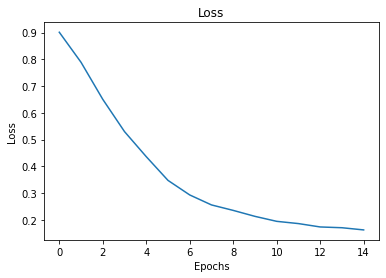

In [ ]:
#access history attribute to get the record
history = model2_val.history

#plot loss and then accuracy over time
plt.figure()
plt.plot(history['loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

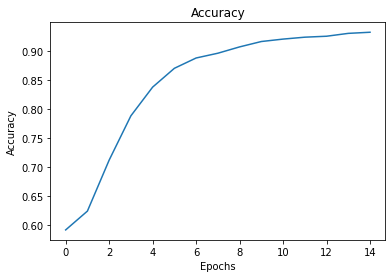

In [ ]:
plt.figure()
plt.plot(history['accuracy'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

**MENGGUNAKAN MODEL L2 REGULARIZATION**

In [ ]:
early_stopping = [EarlyStopping(monitor='accuracy', patience=10)]

In [ ]:
#applying L2 regularization layer
np.random.seed(10)
l2_model = Sequential()

l2_model.add(Embedding(10000, embedding_size))
l2_model.add(LSTM(25, return_sequences=True))
l2_model.add(GlobalMaxPool1D())
l2_model.add(Dropout(0.5))
l2_model.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
l2_model.add(Dropout(0.5))
l2_model.add(Dense(3, activation='softmax'))

In [ ]:
l2_model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [ ]:
l2_model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, None, 100)         1000000   
_________________________________________________________________
lstm_17 (LSTM)               (None, None, 25)          12600     
_________________________________________________________________
global_max_pooling1d_17 (Glo (None, 25)                0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 50)                1300      
_________________________________________________________________
dropout_23 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 3)               

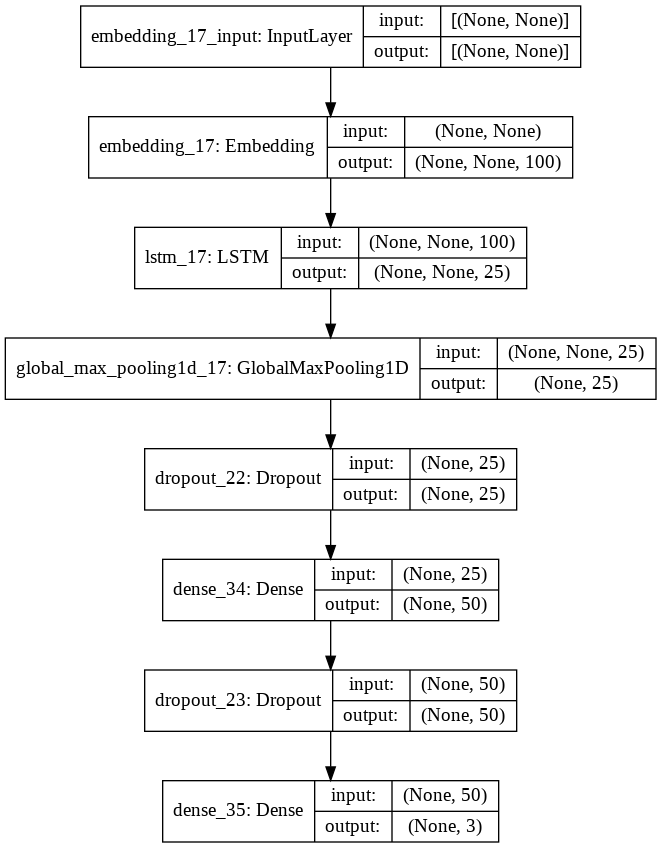

In [ ]:
keras.utils.plot_model(l2_model, "l2_model_function.png", show_shapes=True)

In [ ]:
#increasing epochs to 50
l2_model_val = l2_model.fit(X_train_token, y_train_enc, 
                            epochs=50, 
                            batch_size=256, 
                            callbacks=early_stopping)

Epoch 1/50
27/27 [==============================] - 6s 132ms/step - loss: 1.1652 - accuracy: 0.5492
Epoch 2/50
27/27 [==============================] - 4s 133ms/step - loss: 1.0243 - accuracy: 0.5789
Epoch 3/50
27/27 [==============================] - 4s 130ms/step - loss: 0.9751 - accuracy: 0.5915
Epoch 4/50
27/27 [==============================] - 4s 131ms/step - loss: 0.9468 - accuracy: 0.5965
Epoch 5/50
27/27 [==============================] - 4s 132ms/step - loss: 0.8971 - accuracy: 0.6180
Epoch 6/50
27/27 [==============================] - 4s 133ms/step - loss: 0.8130 - accuracy: 0.6653
Epoch 7/50
27/27 [==============================] - 4s 130ms/step - loss: 0.7128 - accuracy: 0.7302
Epoch 8/50
27/27 [==============================] - 4s 131ms/step - loss: 0.6377 - accuracy: 0.7756
Epoch 9/50
27/27 [==============================] - 4s 130ms/step - loss: 0.5760 - accuracy: 0.8089
Epoch 10/50
27/27 [==============================] - 4s 131ms/step - loss: 0.5229 - accuracy: 0.8277

In [ ]:
evaluate_nn(l2_model, X_train_token, X_test_token, y_train_enc, y_test_enc)

70/70 [==============================] - 1s 12ms/step - loss: 1.8863 - accuracy: 0.6550
----------
Training Loss: 0.104 
Training Accuracy: 0.961
----------
Test Loss: 1.89 
Test Accuracy: 0.655


Pada model L2 Regression dihasilkan training accuracy tertinggi dibandungkan dengan model-model sebelumnya, tetapi regularisasi tidak terlalu membantu untuk meningkatkan skor test accuracy. Model selanjutnya yang akan dicoba adalah regularisasi L1.

Text(0, 0.5, 'Loss')

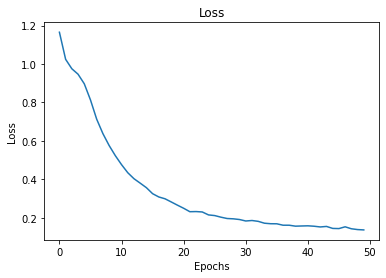

In [ ]:
#access history attribute to get the record
history = l2_model_val.history

#plot loss and then accuracy over time
plt.figure()
plt.plot(history['loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

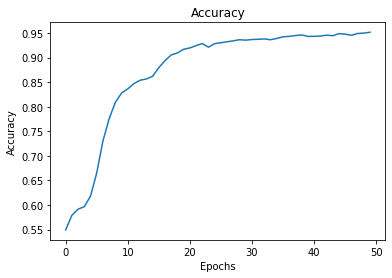

In [ ]:
plt.figure()
plt.plot(history['accuracy'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

**MENGGUNAKAN MODEL L1 REGULARIZATION**

In [ ]:
#adding L1 regulairzer layer
np.random.seed(10)
l1_model = Sequential()

In [ ]:
l1_model.add(Embedding(10000, embedding_size))
l1_model.add(LSTM(25, return_sequences=True))
l1_model.add(GlobalMaxPool1D())
l1_model.add(Dropout(0.5))
l1_model.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l1(0.005)))
l1_model.add(Dropout(0.5))
l1_model.add(Dense(3, activation='softmax'))

In [ ]:
l1_model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [ ]:
l1_model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, None, 100)         1000000   
_________________________________________________________________
lstm_18 (LSTM)               (None, None, 25)          12600     
_________________________________________________________________
global_max_pooling1d_18 (Glo (None, 25)                0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 50)                1300      
_________________________________________________________________
dropout_25 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 3)               

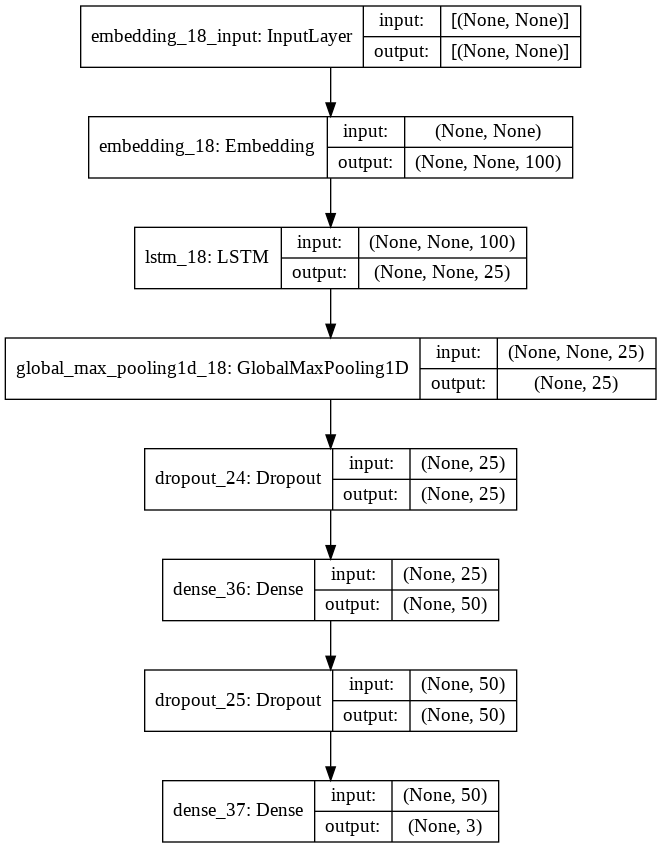

In [ ]:
keras.utils.plot_model(l1_model, "l1_model_function.png", show_shapes=True)

In [ ]:
l1_model_val = l1_model.fit(X_train_token, y_train_enc, 
                            epochs=50, 
                            batch_size=256, 
                            callbacks=early_stopping)

Epoch 1/50
27/27 [==============================] - 6s 133ms/step - loss: 1.7972 - accuracy: 0.4827
Epoch 2/50
27/27 [==============================] - 4s 133ms/step - loss: 1.5649 - accuracy: 0.5964
Epoch 3/50
27/27 [==============================] - 4s 132ms/step - loss: 1.4294 - accuracy: 0.5955
Epoch 4/50
27/27 [==============================] - 4s 133ms/step - loss: 1.3044 - accuracy: 0.6067
Epoch 5/50
27/27 [==============================] - 4s 132ms/step - loss: 1.1974 - accuracy: 0.6056
Epoch 6/50
27/27 [==============================] - 4s 131ms/step - loss: 1.0908 - accuracy: 0.6082
Epoch 7/50
27/27 [==============================] - 4s 130ms/step - loss: 0.9867 - accuracy: 0.6244
Epoch 8/50
27/27 [==============================] - 4s 132ms/step - loss: 0.8844 - accuracy: 0.6601
Epoch 9/50
27/27 [==============================] - 4s 130ms/step - loss: 0.7959 - accuracy: 0.7073
Epoch 10/50
27/27 [==============================] - 4s 131ms/step - loss: 0.7277 - accuracy: 0.7457

In [ ]:
evaluate_nn(l1_model, X_train_token, X_test_token, y_train_enc, y_test_enc)

70/70 [==============================] - 1s 12ms/step - loss: 1.3461 - accuracy: 0.6268
----------
Training Loss: 0.233 
Training Accuracy: 0.939
----------
Test Loss: 1.35 
Test Accuracy: 0.627


Setelah menerapkan L1 regression terlihat bahwa hasil training accuracy dan testing accuracy menurun dibandingkan dengan model L2 regression sehingga untuk percobaan kali ini model L2 regression mengungguli model-model lain




Text(0, 0.5, 'Loss')

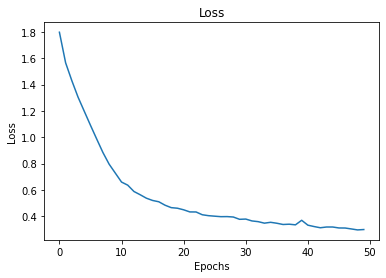

In [ ]:
#access history attribute to get the record
history = l1_model_val.history

#plot loss and then accuracy over time
plt.figure()
plt.plot(history['loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

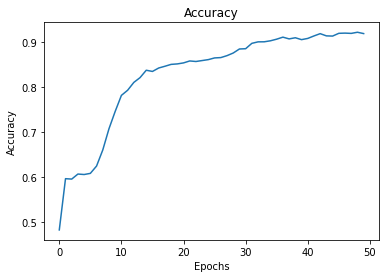

In [ ]:
plt.figure()
plt.plot(history['accuracy'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# **MODEL INFERENCE**

In [ ]:
evaluate_nn(model1, X_train_token, X_test_token, y_train_enc, y_test_enc)

70/70 [==============================] - 1s 12ms/step - loss: nan - accuracy: 0.0613
----------
Training Loss: nan 
Training Accuracy: 0.0646
----------
Test Loss: nan 
Test Accuracy: 0.0613


In [ ]:
evaluate_nn(model2, X_train_token, X_test_token, y_train_enc, y_test_enc)

70/70 [==============================] - 1s 12ms/step - loss: 1.9991 - accuracy: 0.6546
----------
Training Loss: 0.114 
Training Accuracy: 0.948
----------
Test Loss: 2.0 
Test Accuracy: 0.655


In [ ]:
evaluate_nn(l2_model, X_train_token, X_test_token, y_train_enc, y_test_enc)

70/70 [==============================] - 1s 12ms/step - loss: 1.8863 - accuracy: 0.6550
----------
Training Loss: 0.104 
Training Accuracy: 0.961
----------
Test Loss: 1.89 
Test Accuracy: 0.655


In [ ]:
evaluate_nn(l1_model, X_train_token, X_test_token, y_train_enc, y_test_enc)

70/70 [==============================] - 1s 12ms/step - loss: 1.3461 - accuracy: 0.6268
----------
Training Loss: 0.233 
Training Accuracy: 0.939
----------
Test Loss: 1.35 
Test Accuracy: 0.627


# **MODEL ANALYSIS**



*   Pada percobaan kali ini dilakukan 4 pemodelan untuk menemukan model terbaik untuk melakukan sentimen analisis
*   Model pertama dilakukan secara standar dengan epoch rendah yaitu 10 epoch dan dihasilkan hasil yang baik pada 5 epoch pertama akan tetapi 5 epoch selanjutnya nilai akurasi turun secara drastis. Hal ini masih diselidiki apa penyebab dari nilai akurasi yang turun drastis

*   Dilakukan model improvement terhadap model pertama dengan membuat model kedua dengan menambahkan jumlah epoch dan terlihat bahwa model kedua menunjukkan kenikan nilai akurasi yang signifikan namun untuk akurasi testing set nya masih rendah
*   Untuk mencari model terbaik maka dibuat model ketiga dengan L2 regression. Pada model ini ditambahkan early stopping yang bertujuan untuk dapat memangkas runtime yang tidak perlu. Hasil model ketiga menunjukkan nilai akurasi training yang lebih baik dibanding model-model sebelumnya namun sayangnya pada metode L2 regression ini masih belum bisa memperbaiki nilai akurasi testingnya

*   Selain L2 regression terdapat L1 regression untuk dijadikan model keempat. Hasilnya nilai akurasi L1 regression menurun baik pada training set maupun testing set
*   Kesimpulan dari percobaan empat model ini didapatkan model terbaik dengan menggunakan L2 regresssion







# **OVERALL ANALYSIS**

Dari semua iterasi model yang saya coba, model dengan menggunakan GloVe paling berhasil mencapai akurasi tinggi. Namun, setelah mencoba beberapa teknik berbeda, masalah overfitting masih belum terlalu membaik.

model terbaik yang saya hasilkan memiliki akurasi pada training set sebesar 96.1% akan tetapi hasil akurasi pada testing set tidak sebaik training nya yaitu 65.5%. Model terbaik yang dihasilkan adalah model L2 regression

# **KESIMPULAN**

Dataset kali ini menyajikan persebaran data yang tidak seimbang (imbalance) pada kelasnya yang cukup signifikan karena sebagian besar sampel diberi label netral, indikator sentimen menjadi lebih sedikit.

Untuk meningkatkan nilai akurasi model pada training set dan testing set dan dapat lebih general persebarannya, disarankan untuk mengumpulkan lebih banyak data yang memiliki persentase label yang lebih tinggi yang menunjukkan sentimen positif atau negatif. Menambahkan lebih banyak data juga dapat memungkinkan penggunaan model nlp yang lebih baik, yang dapat membantu mengurangi waktu proses.